# A Lesson on Manifold-Constrained Hyper Connections with JAX
A paper recently published by DeepSeek, [mHC: Manifold-Constrained Hyper-Connections](https://arxiv.org/pdf/2512.24880), introduces a new residual connection paradigm. 

I thought this would be a great opportunity to go over a few concepts at once:
1. **Residual connections**, their importance in deep learning, and what **mHC** is.
2. **[JAX](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html)**, an ML library built by Google that's gaining popularity, and [FLAX NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html), a high-level neural network library for JAX ([Gemini 3](https://gemini.google.com/app) was trained using JAX).

### Prerequisites
You probably need some basic understanding of neural networks and Python programming. Familiarity with Pytorch would be helpful since FLAX NNX has a fairly similar API, but not required.

## The Necessity of Residual Connections

In early deep learning (pre-2015), training very deep networks was notoriously difficult due to the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). As gradients backpropagate through many layers, they multiply, and if the eigenvalues of the weight matrices are small, the gradients shrink exponentially effectively "killing" the learning in earlier layers.

This led to results like the one below, where the 56-layer network, which you might expect to perform better than the 20-layer network, actually performs worse on both the training and test sets.
![train_error_comparison](train_error_comparison.png)

### The Solution: Residual Connections

The [Residual Connection](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) allows the gradient to flow directly through the identity path ($x_l$) unimpeded. Now, instead of each layer learning a direct mapping from $x_l$ to $x_{l+1}$, it learns a residual function $F(x_l)$ that is added to the input. Gradient signals are effectively unimpeded as they can flow through the identity path.

$$
x_{l+1} = x_l + F(x_l)
$$

This simple addition is used in almost every major modern architecture:
*   [ResNet](https://huggingface.co/docs/transformers/v4.32.0/model_doc/resnet) (Vision)
*   [Transformers](https://huggingface.co/docs/transformers/index) (LLMs: [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), [Llama](https://arxiv.org/pdf/2302.13971), [Claude](https://en.wikipedia.org/wiki/Claude_(language_model)), etc.) in the form of the "Add & Norm" blocks.
*   [Diffusion Models](https://arxiv.org/pdf/2209.00796) (DALL-E, Stable Diffusion, etc.) also use residual connections extensively in their U-Net architectures.



![alt text](basic_res_layer.png)

# A Basic Residual Block with FLAX NNX
Let's implement a simple residual block using FLAX NNX.

JAX has traditionally relied on a purely functional programming model (stateless functions, immutable data). **NNX** is a new experimental API from Flax that brings a more familiar, Pythonic, Object-Oriented experience to JAX, similar to PyTorch, while retaining JAX's transform capabilities (`jit`, `grad`, `vmap`).

In NNX:
*   **Modules** are Python objects that hold state (`nnx.Param`, `nnx.Variable`).
*   **State management** is explicit but handled for you during transforms.

In [1]:
!pip install -q -U jax[tpu] flax optax datasets pillow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.4/493.4 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 162.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 15.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.5/180.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.9 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
# Check JAX devices - should see TPU on Colab/TPU VM
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"JAX backend: {jax.default_backend()}")

JAX version: 0.9.0.1
JAX devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]
JAX backend: tpu


In [4]:
class ResBlock(nnx.Module):
    def __init__(self, channels, rngs: nnx.Rngs):
        # A simple Pre-Activation ResNet block
        self.norm1 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv1 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.norm2 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv2 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
    
    def __call__(self, x, train=True):
        # Identity path
        residual = x
        
        # F(x) path
        y = self.norm1(x, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv1(y)
        
        y = self.norm2(y, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv2(y)
        
        # Add residual
        return residual + y


The code above implements a simple residual block using FLAX NNX.

The `ResBlock` class inherits from `nnx.Module`, which is the base class for all neural network modules in FLAX NNX. Unlike older Flax versions, an NNX module is a native [PyTree](https://docs.jax.dev/en/latest/pytrees.html) (a fundamental container-like structure in JAX), meaning it can be passed directly into JAX transformations.

We then define a series of `nnx.BatchNorm` and `nnx.Conv` layers in the `__init__` method, which are standard components in convolutional neural networks, and are used to normalise the inputs, which stabilises training, and to apply convolutional filters, which extract features from the 2D input data, allowing the network to learn spatial hierarchies.

While [JAX is a functional programming library](https://www.youtube.com/watch?v=SMAsCd4W5Z0), FLAX NNX allows us to use an object-oriented, stateful approach to define our models, making it more intuitive for those familiar with traditional deep learning frameworks.

In the `__call__` method, we define the forward pass using these layers. The final output, `residual + y`, adds the unmodified input (`residual`) to the transformed output (`y`), implementing the residual connection.

In [5]:
# Create an instance of ResBlock to display its structure
rngs = nnx.Rngs(0)
res_block = ResBlock(channels=64, rngs=rngs)
nnx.display(res_block)

## A Basic ResNet
Lets now use our `ResBlock`s to build a simple ResNet-like architecture.

In [6]:
class ResNetModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        
        # Stack blocks - use nnx.List so NNX can track submodules
        self.blocks = nnx.List([
            ResBlock(width, rngs=rngs) for _ in range(depth)
        ])
        
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        
        # Global Average Pooling
        x = jnp.mean(x, axis=(1, 2))
        x = self.linear_out(x)
        return x

In [7]:
# Test Instantiation
rngs = nnx.Rngs(0)
model = ResNetModel(width=64, depth=4, rngs=rngs)
dummy_input = jnp.ones((1, 32, 32, 3))
output = model(dummy_input, train=False)
print(f"Model Output Shape: {output.shape}")

Model Output Shape: (1, 100)


In [8]:
nnx.display(model)

The code above implements a simple ResNet-like model using FLAX NNX. 

We use an `nnx.Conv` layer, a series of our `ResBlock`s, and a final `nnx.BatchNorm` and `nnx.Linear` layer to get the final logits used for class prediction`.

The `__call__` method defines the forward pass using these layers, as well as activation functions to introduce non-linearity, and a Global Average Pooling (GAP) operation to reduce the spatial dimensions of the output before the final linear layer.

![alt text](basic_resnet.png)

# Training a ResNet with JAX and FLAX NNX
Now that we have our ResNet model defined, let's set up a training loop using JAX directly on TPU.

### Dataset
We'll use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

We'll use the HuggingFace `datasets` library to load and preprocess the dataset.

In [9]:
# Load CIFAR-100 using HuggingFace datasets
dataset = load_dataset("cifar100")

def preprocess_split(split_data):
    """Convert a HuggingFace dataset split to numpy arrays."""
    images = np.array([np.array(img) for img in split_data['img']], dtype='float32')
    labels = np.array(split_data['fine_label'], dtype='int32')
    
    # Normalize to [0, 1] then standardize with CIFAR-100 stats
    images = images / 255.0
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    images = (images - mean) / std
    
    return images, labels

train_images, train_labels = preprocess_split(dataset['train'])
test_images, test_labels = preprocess_split(dataset['test'])

print(f"Train: {train_images.shape}, {train_labels.shape}")
print(f"Test:  {test_images.shape}, {test_labels.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cifar100/train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

cifar100/test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Train: (50000, 32, 32, 3), (50000,)
Test:  (10000, 32, 32, 3), (10000,)


# Visualize some samples

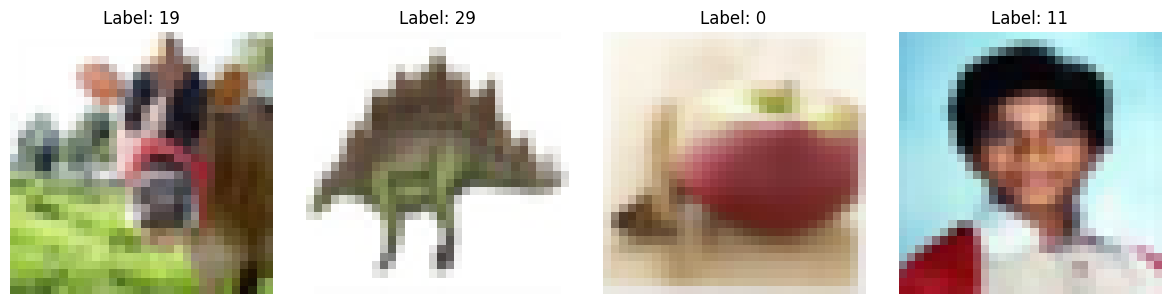

In [10]:
# Visualize some samples (unnormalized)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = np.array(dataset['train'][i]['img'])
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {dataset['train'][i]['fine_label']}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [11]:
def train_model(model_cls, model_kwargs, train_images, train_labels, 
                test_images, test_labels,
                epochs=5, learning_rate=1e-3, batch_size=128):
    """
    Simple training loop using JAX directly on the available device (TPU/GPU/CPU).
    Evaluates on the test set at the end of each epoch.
    """
    rngs = nnx.Rngs(42)
    model = model_cls(**model_kwargs, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adamw(learning_rate), wrt=nnx.Param)

    @nnx.jit
    def train_step(model, optimizer, images, labels):
        def loss_fn(model):
            logits = model(images, train=True)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (jnp.argmax(logits, axis=-1) == labels).mean()
            return loss, acc

        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, acc), grads = grad_fn(model)
        optimizer.update(model, grads)
        return loss, acc

    @nnx.jit
    def eval_step(model, images, labels):
        logits = model(images, train=False)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        acc = (jnp.argmax(logits, axis=-1) == labels).mean()
        return loss, acc

    num_train = train_images.shape[0]
    steps_per_epoch = num_train // batch_size
    num_test = test_images.shape[0]
    eval_steps = num_test // batch_size
    
    history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}

    for epoch in range(epochs):
        # --- Training ---
        perm = np.random.permutation(num_train)
        epoch_loss, epoch_acc = 0.0, 0.0

        for step in range(steps_per_epoch):
            idx = perm[step * batch_size : (step + 1) * batch_size]
            loss, acc = train_step(model, optimizer, 
                                   jnp.array(train_images[idx]), 
                                   jnp.array(train_labels[idx]))
            epoch_loss += float(loss)
            epoch_acc += float(acc)

        avg_train_loss = epoch_loss / steps_per_epoch
        avg_train_acc = epoch_acc / steps_per_epoch

        # --- Evaluation ---
        eval_loss, eval_acc = 0.0, 0.0
        for step in range(eval_steps):
            idx = slice(step * batch_size, (step + 1) * batch_size)
            loss, acc = eval_step(model, 
                                  jnp.array(test_images[idx]), 
                                  jnp.array(test_labels[idx]))
            eval_loss += float(loss)
            eval_acc += float(acc)

        avg_eval_loss = eval_loss / eval_steps
        avg_eval_acc = eval_acc / eval_steps

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['eval_loss'].append(avg_eval_loss)
        history['eval_acc'].append(avg_eval_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
              f"Eval Loss: {avg_eval_loss:.4f}, Eval Acc: {avg_eval_acc:.4f}")

    return model, history

## 🔍 Understanding the Training Loop & JAX Concepts

### The Training Loop at a High Level

Our `train_model` function follows a standard mini-batch SGD pattern, but expressed in JAX's functional style:

1. **Shuffle & batch**: each epoch, we generate a random permutation of indices and slice the data into chunks of `batch_size=4096`.
2. **Forward + backward**: `nnx.value_and_grad` traces the model's forward pass *and* computes gradients in a single call via reverse-mode autodiff.
3. **Parameter update**: `optimizer.update(model, grads)` applies the AdamW update rule to every `nnx.Param` leaf in the model's state graph.
4. **Eval pass**: after each epoch we run the same model with `train=False` (so `BatchNorm` uses running statistics) and log eval loss/accuracy.

That's it. No `.backward()`, no `.zero_grad()`, no `model.train()` / `model.eval()` mode toggles. The functional design makes every side effect explicit.

---

### Why is RNG explicit? (`nnx.Rngs`)

JAX programs must be **pure functions**; given the same inputs, they must produce the same outputs. That rules out a hidden global random state like `torch.manual_seed()`.

Instead, JAX uses *splittable* PRNG (Pseudo-Random Number Generator) keys: a single key is deterministically split into children, so every random operation receives its own unique, reproducible key. `nnx.Rngs(42)` is NNX's convenience wrapper: it creates a root key from seed `42` and automatically splits fresh sub-keys each time a layer (e.g. `Dropout`) asks for randomness. This means:

- **Reproducibility is guaranteed**: same seed → same weights, same dropout masks, same results.
- **Parallelism is safe**: independent keys can be used on different devices without coordination.

---

### What is `nnx.Optimizer`?

`nnx.Optimizer` bridges **Optax** (JAX's optimizer library) and **NNX's mutable object graph**.

```python
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate), wrt=nnx.Param)
```

- `model`: the NNX module whose parameters we want to train.
- `optax.adamw(lr)`: a *pure-function* optimizer that knows nothing about NNX; it just maps `(state, grads) → (state, updates)`.
- `wrt=nnx.Param`: tells NNX *which* variable type to differentiate and update. `BatchNorm` running statistics (`nnx.BatchStat`) are **excluded** automatically.

When we call `optimizer.update(model, grads)`, NNX internally:
1. Extracts the `nnx.Param` leaves from `model`.
2. Feeds them + the matching gradients into the Optax update rule.
3. Writes the new values back into the model **in-place**.

This is what makes NNX feel imperative while remaining functionally sound under the hood.

---

### What does `@nnx.jit` do, and why is it unique?

`@jax.jit` compiles a Python function into an optimized **XLA HLO program** that runs on the accelerator. But raw `jax.jit` requires **pure functions**, no Python objects with mutable state allowed.

NNX modules *are* mutable Python objects (they hold parameters, batch-norm stats, optimizer state, etc.). `@nnx.jit` solves this by automatically:

1. **Extracting** all mutable state from the object graph into flat JAX arrays (the "state split").
2. **Tracing** the pure-function body through XLA.
3. **Re-injecting** the updated state back into the live Python objects.

This is unique to NNX, you get the ergonomics of PyTorch-style mutable objects **plus** the full power of XLA compilation, all without manually managing `state` dicts or `apply()` calls (as was required in the older Flax Linen API).

The first call to a `@nnx.jit` function pays a one-time tracing cost; subsequent calls with the same input shapes hit the compiled cache and run at full hardware speed.

---

### ⚡ TPU v5e-1 vs Common GPUs (for *this* workload)

We are training on **CIFAR-100** (32 × 32 × 3 images, 100 classes) with `batch_size = 4096` and `epochs = 100`.

A single batch occupies roughly **4096 × 32 × 32 × 3 × 4 bytes ≈ 50 MB** in float32, so memory is not a bottleneck on *any* modern accelerator. The comparison below focuses on raw compute throughput and memory bandwidth, which determine wall-clock time for this small-image, large-batch workload.

| Spec | **TPU v5e-1** | NVIDIA T4 | NVIDIA V100 | NVIDIA A100 (40 GB) |
|---|---|---|---|---|
| Peak bf16 / fp16 TFLOPS | **197** | 65 | 125 | 312 |
| HBM / VRAM | 16 GB HBM | 16 GB GDDR6 | 16 GB HBM2 | 40 GB HBM2e |
| Memory bandwidth | **800 GB/s** | 320 GB/s | 900 GB/s | 1,555 GB/s |
| Typical cloud cost | ~$1.20/hr | ~$0.35/hr | ~$2.48/hr | ~$3.67/hr |

**Key takeaways for our workload:**

- **TPU v5e-1 vs T4**: The v5e delivers **~3× the peak FLOPS** and **2.5× the memory bandwidth** at a moderate cost premium. For batch_size=4096, the T4 would likely be compute-bound and train significantly slower.
- **TPU v5e-1 vs V100**: Similar memory capacity, comparable bandwidth, but the v5e has **~1.6× more bf16 FLOPS** at roughly half the cost. The v5e is the clear winner for this workload.
- **TPU v5e-1 vs A100**: The A100 has **~1.6× more FLOPS** and **~2× the bandwidth**, but at **~3× the cost**. For a small model on CIFAR-100, the A100's extra headroom is overkill. The v5e delivers better price/performance.
- **XLA advantage**: JAX compiles the entire training step (forward + backward + optimizer) into a *single fused XLA program*. This eliminates Python overhead and kernel-launch gaps that frameworks like PyTorch (eager mode) pay on GPUs. On TPU, this fusion is especially effective because the XLA compiler has full visibility into the TPU's systolic array and HBM layout.

**Bottom line:** For this notebook's workload (small images, moderate model, large batch), a single TPU v5e-1 chip hits a sweet spot of **high throughput, low cost, and zero-friction JAX integration**.

In [ ]:
# Train the ResNet model
resnet_model, resnet_history = train_model(
    ResNetModel,
    {"width": 64, "depth": 4, "num_classes": 100},
    train_images, train_labels,
    test_images, test_labels,
    epochs=100, learning_rate=1e-3, batch_size=4096
)
print(f"\nResNet Final - Train Loss: {resnet_history['train_loss'][-1]:.4f}, Eval Acc: {resnet_history['eval_acc'][-1]:.4f}")

Epoch 1/100 - Train Loss: 4.4782, Train Acc: 0.0389 | Eval Loss: 5.9061, Eval Acc: 0.0287
Epoch 2/100 - Train Loss: 4.2876, Train Acc: 0.0675 | Eval Loss: 5.2462, Eval Acc: 0.0350
Epoch 3/100 - Train Loss: 4.1691, Train Acc: 0.0878 | Eval Loss: 4.4920, Eval Acc: 0.0503
Epoch 4/100 - Train Loss: 4.0613, Train Acc: 0.1040 | Eval Loss: 4.3962, Eval Acc: 0.0538
Epoch 5/100 - Train Loss: 3.9625, Train Acc: 0.1169 | Eval Loss: 4.4948, Eval Acc: 0.0549
Epoch 6/100 - Train Loss: 3.8637, Train Acc: 0.1324 | Eval Loss: 4.2154, Eval Acc: 0.0741
Epoch 7/100 - Train Loss: 3.7694, Train Acc: 0.1461 | Eval Loss: 4.1197, Eval Acc: 0.0870
Epoch 8/100 - Train Loss: 3.6769, Train Acc: 0.1618 | Eval Loss: 4.1983, Eval Acc: 0.0756
Epoch 9/100 - Train Loss: 3.5902, Train Acc: 0.1744 | Eval Loss: 4.1885, Eval Acc: 0.0767
Epoch 10/100 - Train Loss: 3.5108, Train Acc: 0.1857 | Eval Loss: 4.1591, Eval Acc: 0.0837
Epoch 11/100 - Train Loss: 3.4303, Train Acc: 0.1982 | Eval Loss: 4.1336, Eval Acc: 0.0880
Epoch 12

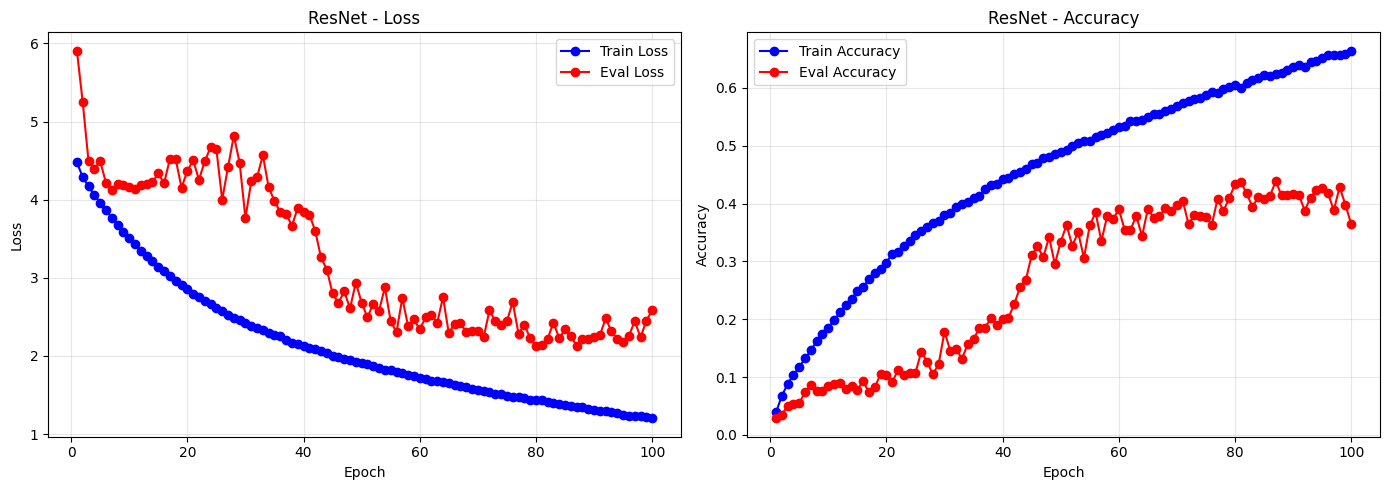

In [13]:
def plot_history(history, title="Training Results"):
    """Plot train/eval loss and accuracy curves."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    ax1.plot(epochs, history['eval_loss'], 'r-o', label='Eval Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy')
    ax2.plot(epochs, history['eval_acc'], 'r-o', label='Eval Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(resnet_history, title="ResNet")

## Hyper-Connections (HC)

The concept of [Hyper-Connections](https://arxiv.org/pdf/2409.19606) was introduced by ByteDance in 2024, and generalises the Residual Connection. Instead of a fixed Identity mapping ($I \cdot x$), we allow the network to *learn* how to pass information from layer $l$ to $l+1$ using a learnable linear transformation $H^{res}$.

$$ x_{l+1} = H^{res} x_l + H^{post} F(H^{pre} x_l) $$

Here, $x$ effectively contains multiple "streams" of information. $H^{res}$ allows these streams to mix linearly in the skip connection.

![hc_layer](hc_layer.png)

### The Problem: Instability
While this increases expressivity (the network can choose to ignore the skip, or amplify specific features), it introduces a major flaw: **Gain Unboundedness**.
If the eigenvalues of $H^{res}$ deviate from 1, the signal magnitude can grow or shrink exponentially with depth, just like in plain non-residual networks. This makes training deep HC networks very unstable.

Let's implement an HC Block where we split our channels into $N$ streams and learn the mixing.
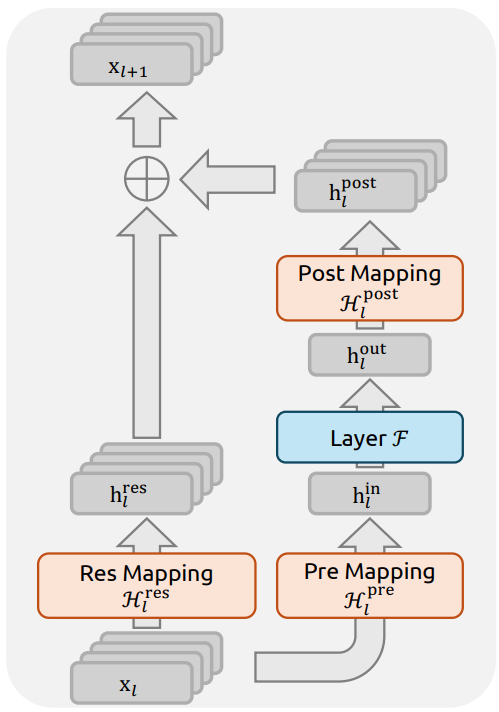

In [18]:
class HCBlock(nnx.Module):
    def __init__(self, channels, num_streams, rngs: nnx.Rngs):
        self.num_streams = num_streams
        self.channels = channels
        self.dim_per_stream = channels // num_streams
        
        # H_res: Unconstrained learnable mixing matrix (num_streams x num_streams)
        # Initialized near identity so it starts as a standard residual connection.
        # Unlike mHC, this is NOT projected onto the Birkhoff Polytope,
        # so eigenvalues can drift and cause gain unboundedness.
        self.h_res_weight = nnx.Param(
            jnp.eye(num_streams) + 0.01 * jax.random.normal(rngs.params(), (num_streams, num_streams))
        )
        
        # F(x) path — same 2-conv structure as ResBlock for iso-compute comparison
        self.norm1 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv1 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.norm2 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv2 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)

    def __call__(self, x, train=True):
        B, H, W, C = x.shape
        
        # 1. Skip Path: unconstrained learnable mixing across streams
        x_reshaped = x.reshape(B, H, W, self.num_streams, self.dim_per_stream)
        skip = jnp.einsum('ij, bhwjk -> bhwik', self.h_res_weight, x_reshaped)
        skip = skip.reshape(B, H, W, C)
        
        # 2. F(x) Path (matches ResBlock: norm-relu-conv × 2)
        y = self.norm1(x, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv1(y)
        y = self.norm2(y, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv2(y)
        
        return skip + y

class HCModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, num_streams=4, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.blocks = nnx.List([HCBlock(width, num_streams, rngs=rngs) for _ in range(depth)])
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        return self.linear_out(x)


Epoch 1/100 - Train Loss: 4.4644, Train Acc: 0.0377 | Eval Loss: 6.1179, Eval Acc: 0.0253
Epoch 2/100 - Train Loss: 4.2639, Train Acc: 0.0711 | Eval Loss: 5.7892, Eval Acc: 0.0291
Epoch 3/100 - Train Loss: 4.1369, Train Acc: 0.0916 | Eval Loss: 4.6398, Eval Acc: 0.0403
Epoch 4/100 - Train Loss: 4.0183, Train Acc: 0.1084 | Eval Loss: 4.4279, Eval Acc: 0.0529
Epoch 5/100 - Train Loss: 3.9157, Train Acc: 0.1201 | Eval Loss: 4.2645, Eval Acc: 0.0636
Epoch 6/100 - Train Loss: 3.8184, Train Acc: 0.1367 | Eval Loss: 4.1524, Eval Acc: 0.0807
Epoch 7/100 - Train Loss: 3.7257, Train Acc: 0.1498 | Eval Loss: 4.1489, Eval Acc: 0.0797
Epoch 8/100 - Train Loss: 3.6405, Train Acc: 0.1629 | Eval Loss: 4.1450, Eval Acc: 0.0789
Epoch 9/100 - Train Loss: 3.5560, Train Acc: 0.1790 | Eval Loss: 4.1463, Eval Acc: 0.0752
Epoch 10/100 - Train Loss: 3.4806, Train Acc: 0.1920 | Eval Loss: 4.1248, Eval Acc: 0.0806
Epoch 11/100 - Train Loss: 3.3998, Train Acc: 0.2053 | Eval Loss: 4.1584, Eval Acc: 0.0767
Epoch 12

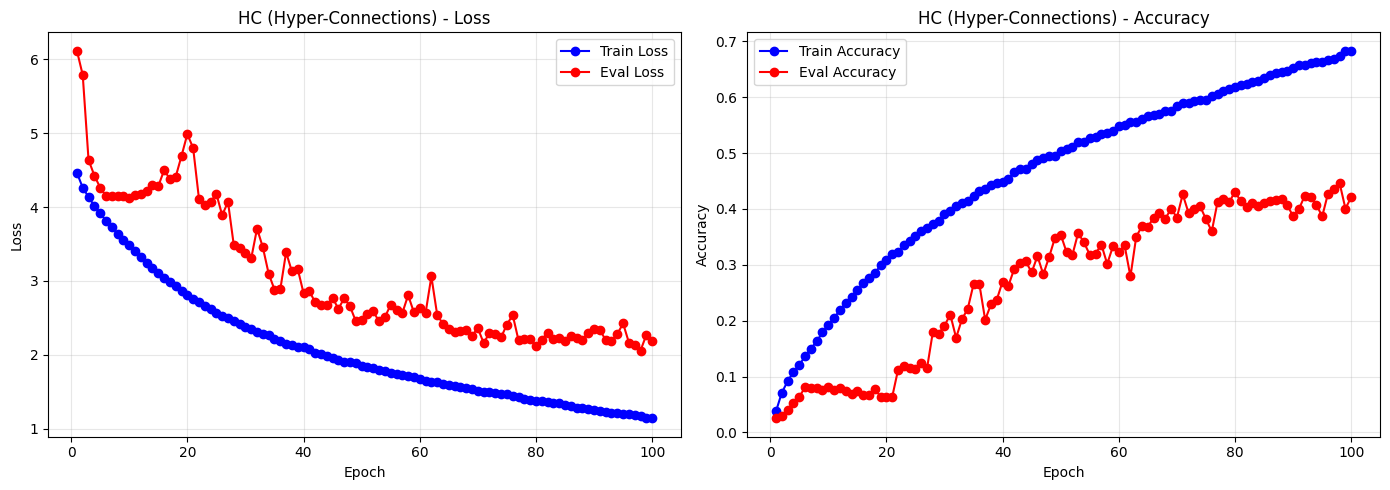


HC Final - Train Loss: 1.1400, Eval Acc: 0.4210


In [19]:
# Train HC Model
# Note: This might be unstable or diverge if trained for long or if depth is large.
hc_model, hc_history = train_model(
    HCModel,
    {'width': 64, 'depth': 4, 'num_streams': 4, 'num_classes': 100},
    train_images, train_labels,
    test_images, test_labels,
    epochs=100, learning_rate=1e-3, batch_size=4096
)
plot_history(hc_history, title="HC (Hyper-Connections)")
print(f"\nHC Final - Train Loss: {hc_history['train_loss'][-1]:.4f}, Eval Acc: {hc_history['eval_acc'][-1]:.4f}")

# Manifold-Constrained Hyper-Connections (mHC)

The **mHC** paper introduces a solution to the instability of Hyper-Connections: **Manifold Constraints**.
Instead of allowing $H^{res}$ to be any matrix, we constrain it to the **Birkhoff Polytope** $\mathcal{B}_N$, the set of doubly stochastic matrices.

A Doubly Stochastic Matrix $M$ satisfies:
1.  $M_{ij} \ge 0$ (Non-negative)
2.  $\sum_j M_{ij} = 1$ (Rows sum to 1)
3.  $\sum_i M_{ij} = 1$ (Columns sum to 1)

This constraint ensures that the gain of the residual path is bounded, preventing the signal explosion, while still allowing the network to dynamically mix and route information between streams.

**Basically**, we get the benefits of dynamic mixing (i.e., more capacity to learn complex interactions between streams) but with stability (i.e., no risk of exploding/vanishing signals).

![alt text](mhc_layer.png)
### Construction using Sinkhorn-Knopp
We can learn an unconstrained parameter matrix $W$, and project it onto $\mathcal{B}_N$ using the **Sinkhorn-Knopp algorithm** (iterative row and column normalization). This is a simple and computationally efficient way to enforce the doubly stochastic constraint by alternating normalization of rows and columns until convergence.

$$ H^{res} = \text{Sinkhorn}(\phi(W)) $$

where $\phi$ ensures positivity (e.g., sigmoid/exp).

Let's implement the Sinkhorn projection and the mHC Block.

In [20]:
# Sinkhorn Iteration in JAX
@jax.jit
def sinkhorn_knopp(log_alpha, n_iters=5):
    """Project a matrix onto the Birkhoff Polytope (doubly stochastic matrices)."""
    matrix = jnp.exp(log_alpha)
    
    def body_fn(i, mat):
        # Normalize Rows
        mat = mat / (jnp.sum(mat, axis=-1, keepdims=True) + 1e-6)
        # Normalize Cols
        mat = mat / (jnp.sum(mat, axis=-2, keepdims=True) + 1e-6)
        return mat

    matrix = jax.lax.fori_loop(0, n_iters, body_fn, matrix)
    return matrix

class mHCBlock(nnx.Module):
    def __init__(self, channels, num_streams, rngs: nnx.Rngs):
        self.num_streams = num_streams
        self.channels = channels
        self.dim_per_stream = channels // num_streams
        
        # Raw parameters for the mixing matrix (num_streams x num_streams)
        self.h_res_logits = nnx.Param(jax.random.normal(rngs.params(), (num_streams, num_streams)))
        
        # F(x) path — same 2-conv structure as ResBlock for iso-compute comparison
        self.norm1 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv1 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.norm2 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv2 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
    
    def __call__(self, x, train=True):
        B, H, W, C = x.shape
        
        # 1. Compute Projected H_res (doubly stochastic)
        h_res = sinkhorn_knopp(self.h_res_logits)  # (S, S)
        
        # 2. Reshape x to apply mixing on streams: (B, H, W, S, D)
        x_reshaped = x.reshape(B, H, W, self.num_streams, self.dim_per_stream)
        
        # 3. Apply H_res to mix streams
        skip = jnp.einsum('ij, bhwjk -> bhwik', h_res, x_reshaped)
        skip = skip.reshape(B, H, W, C)
        
        # 4. F(x) Path (matches ResBlock: norm-relu-conv × 2)
        y = self.norm1(x, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv1(y)
        y = self.norm2(y, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv2(y)
        
        return skip + y

class mHCModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, num_streams=4, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.blocks = nnx.List([mHCBlock(width, num_streams, rngs=rngs) for _ in range(depth)])
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        return self.linear_out(x)


Epoch 1/100 - Train Loss: 4.4637, Train Acc: 0.0410 | Eval Loss: 4.7548, Eval Acc: 0.0292
Epoch 2/100 - Train Loss: 4.2566, Train Acc: 0.0711 | Eval Loss: 4.5288, Eval Acc: 0.0427
Epoch 3/100 - Train Loss: 4.1224, Train Acc: 0.0914 | Eval Loss: 4.3743, Eval Acc: 0.0564
Epoch 4/100 - Train Loss: 4.0070, Train Acc: 0.1079 | Eval Loss: 4.2840, Eval Acc: 0.0631
Epoch 5/100 - Train Loss: 3.9038, Train Acc: 0.1213 | Eval Loss: 4.2249, Eval Acc: 0.0723
Epoch 6/100 - Train Loss: 3.8052, Train Acc: 0.1355 | Eval Loss: 4.1752, Eval Acc: 0.0771
Epoch 7/100 - Train Loss: 3.7123, Train Acc: 0.1501 | Eval Loss: 4.1503, Eval Acc: 0.0762
Epoch 8/100 - Train Loss: 3.6306, Train Acc: 0.1639 | Eval Loss: 4.1820, Eval Acc: 0.0690
Epoch 9/100 - Train Loss: 3.5459, Train Acc: 0.1783 | Eval Loss: 4.1879, Eval Acc: 0.0684
Epoch 10/100 - Train Loss: 3.4766, Train Acc: 0.1890 | Eval Loss: 4.0754, Eval Acc: 0.0856
Epoch 11/100 - Train Loss: 3.3962, Train Acc: 0.2039 | Eval Loss: 4.0657, Eval Acc: 0.0865
Epoch 12

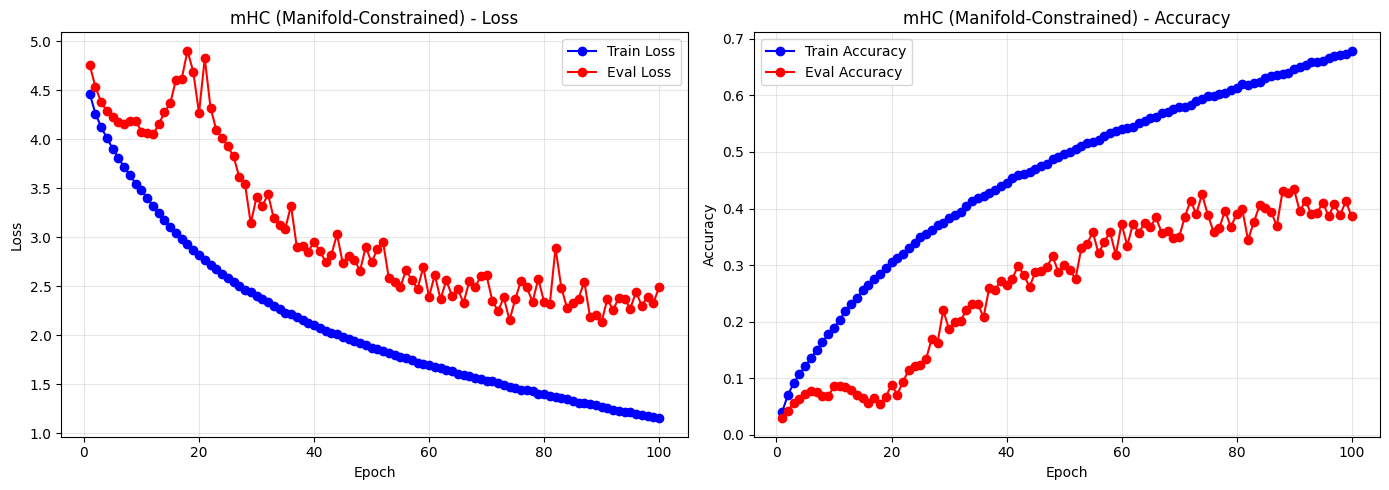


mHC Final - Train Loss: 1.1534, Eval Acc: 0.3866


In [21]:
# Train mHC Model
mhc_model, mhc_history = train_model(
    mHCModel,
    {'width': 64, 'depth': 4, 'num_streams': 4, 'num_classes': 100},
    train_images, train_labels,
    test_images, test_labels,
    epochs=100, learning_rate=1e-3, batch_size=4096
)
plot_history(mhc_history, title="mHC (Manifold-Constrained)")
print(f"\nmHC Final - Train Loss: {mhc_history['train_loss'][-1]:.4f}, Eval Acc: {mhc_history['eval_acc'][-1]:.4f}")

# Comparison and Conclusion

We have implemented three architectures:
1.  **Residual Network:** Uses Identity $I$ for skip connections.
2.  **Hyper-Connected Network:** Uses unconstrained $H$ for skip connections.
3.  **mHC Network:** Uses Doubly Stochastic $P_M$ for skip connections.

The **mHC** architecture provides a middle ground: it offers more expressivity than strict Identity (allowing cross-stream routing) while maintaining the stability guarantees crucial for deep model training, preventing the unbounded gain problem associated with raw Hyper-Connections.

### Next Steps / Exercises
*   Increase the depth to 50+ layers to see the instability of HC vs mHC more clearly.
*   Visualize the learned `h_res` matrices in mHC to see how information routes between streams (e.g., is it learning to permute? broadcast?).
*   Scale up to a Transformer architecture (mHC-Attention) as described in the paper.
